In [1]:
import json
from collections import defaultdict
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

def parse_tab(bench_col):
    tabs = {}
    for name, impls in bench_col.items():
        xs = []
        ys = []
        yerr = []
        for label, impl in impls.items():
            nda = np.array(impl, dtype=np.float64) / 1000
            xs.append(int(label))
            ys.append(nda.mean())
            yerr.append(nda.std())
        tabs[name] = {
            'x': xs,
            'y': ys,
            'yerr': yerr,
        }
    return tabs

In [2]:
results = Path('output.files/results')
qty = 1000000

tabs = {}
for fn in ('mean', 'std'):
    for var in ('ctypes', 'serial_slow', 'serial_fast', 'serial_reference', 'mixed'):
        label = f'{var}_{fn}'
        exps = [
            json.loads((results / f'{v}_{label}_{qty}.json').read_text())
            for v in range(1, 4)
        ]
        tab = exps[0]
        for exp in exps[1:]:
            for m, impl in exp.items():
                for c, ts in impl.items():
                    tab[m][c].extend(ts)
        tabs[label] = parse_tab(tab)

list(tabs)

['ctypes_mean',
 'serial_slow_mean',
 'serial_fast_mean',
 'serial_reference_mean',
 'mixed_mean',
 'ctypes_std',
 'serial_slow_std',
 'serial_fast_std',
 'serial_reference_std',
 'mixed_std']

In [3]:
def get_measures(*tabs):
    return [(tab['y'][r], tab['yerr'][r]) for tab in tabs for r in range(len(tab['x']))]

def ffmt(v):
    vf = float(v)
    return f"{vf:.4}"

def make_row(k, ms):
    return ', '.join([f'[ {x} ]' for x in (k, *(f'{ffmt(m[0])} $plus.minus$ {ffmt(m[1])}' for m in ms))])

ms = get_measures(*list(tabs['serial_fast_mean'].values()))
ss = get_measures(*list(tabs['serial_fast_std'].values()))

print('serial-fast')
print(',\n'.join([
    make_row('ctypes', get_measures(tabs['ctypes_mean']['fast'], tabs['ctypes_std']['fast'])),
    make_row('cffi (setuptools)', (ms[0], ss[0])),
    make_row('cffi (maturin)', (ms[1], ss[1])),
    make_row('PyO3', (ms[2], ss[2])),
    make_row('NumPy', get_measures(tabs['serial_reference_mean']['nparray'], tabs['serial_reference_std']['nparray'])),
]))

ms = get_measures(*list(tabs['serial_slow_mean'].values()))
ss = get_measures(*list(tabs['serial_slow_std'].values()))

print('serial-slow')
print(',\n'.join([
    make_row('ctypes', get_measures(tabs['ctypes_mean']['slow'], tabs['ctypes_std']['slow'])),
    make_row('cffi (setuptools)', (ms[0], ss[0])),
    make_row('cffi (maturin)', (ms[1], ss[1])),
    make_row('PyO3', (ms[2], ss[2])),
    make_row('NumPy', get_measures(tabs['serial_reference_mean']['numpy'], tabs['serial_reference_std']['numpy'])),
]))

serial-fast
[ ctypes ], [ 1.398e+03 $plus.minus$ 160.5 ], [ 1.649e+03 $plus.minus$ 141.6 ],
[ cffi (setuptools) ], [ 632.4 $plus.minus$ 4.714 ], [ 1.259e+03 $plus.minus$ 8.695 ],
[ cffi (maturin) ], [ 637.8 $plus.minus$ 3.855 ], [ 1.266e+03 $plus.minus$ 8.616 ],
[ PyO3 ], [ 636.6 $plus.minus$ 3.238 ], [ 1.255e+03 $plus.minus$ 7.342 ],
[ NumPy ], [ 272.8 $plus.minus$ 18.96 ], [ 1.715e+03 $plus.minus$ 290.5 ]
serial-slow
[ ctypes ], [ 1.982e+05 $plus.minus$ 1.273e+03 ], [ 1.976e+05 $plus.minus$ 1.505e+03 ],
[ cffi (setuptools) ], [ 7.754e+03 $plus.minus$ 25.43 ], [ 7.628e+03 $plus.minus$ 33.18 ],
[ cffi (maturin) ], [ 7.786e+03 $plus.minus$ 48.15 ], [ 7.633e+03 $plus.minus$ 74.29 ],
[ PyO3 ], [ 6.451e+03 $plus.minus$ 50.63 ], [ 7.017e+03 $plus.minus$ 40.74 ],
[ NumPy ], [ 2.519e+04 $plus.minus$ 688.3 ], [ 2.661e+04 $plus.minus$ 729.4 ]


In [16]:
alabels = [10 + i for i in range(9)]
umean = dict(
    **tabs['mixed_mean'],
)
ustd = dict(
    **tabs['mixed_std'],
)
mlabels = np.log2(np.array([float(x) for x in umean['numpy']['x']], dtype=np.float64))
def find_maxerr(tab):
    mv, mx = 0, 0
    for i in range(len(tab['x'])):
        if (v := tab['yerr'][i]) > mv:
            mx = tab['x'][i]
            mv = v
    return mx, mv

print("max yerr mean")
for k, tab in umean.items():
    print(k, find_maxerr(tab))
print("max yerr std")
for k, tab in ustd.items():
    print(k, find_maxerr(tab))

max yerr mean
pyo3 (1024, np.float64(10.555483911008318))
numpy (1024, np.float64(53.26446616247393))
max yerr std
pyo3 (1024, np.float64(11.594242073642517))
numpy (1024, np.float64(63.99753578360143))


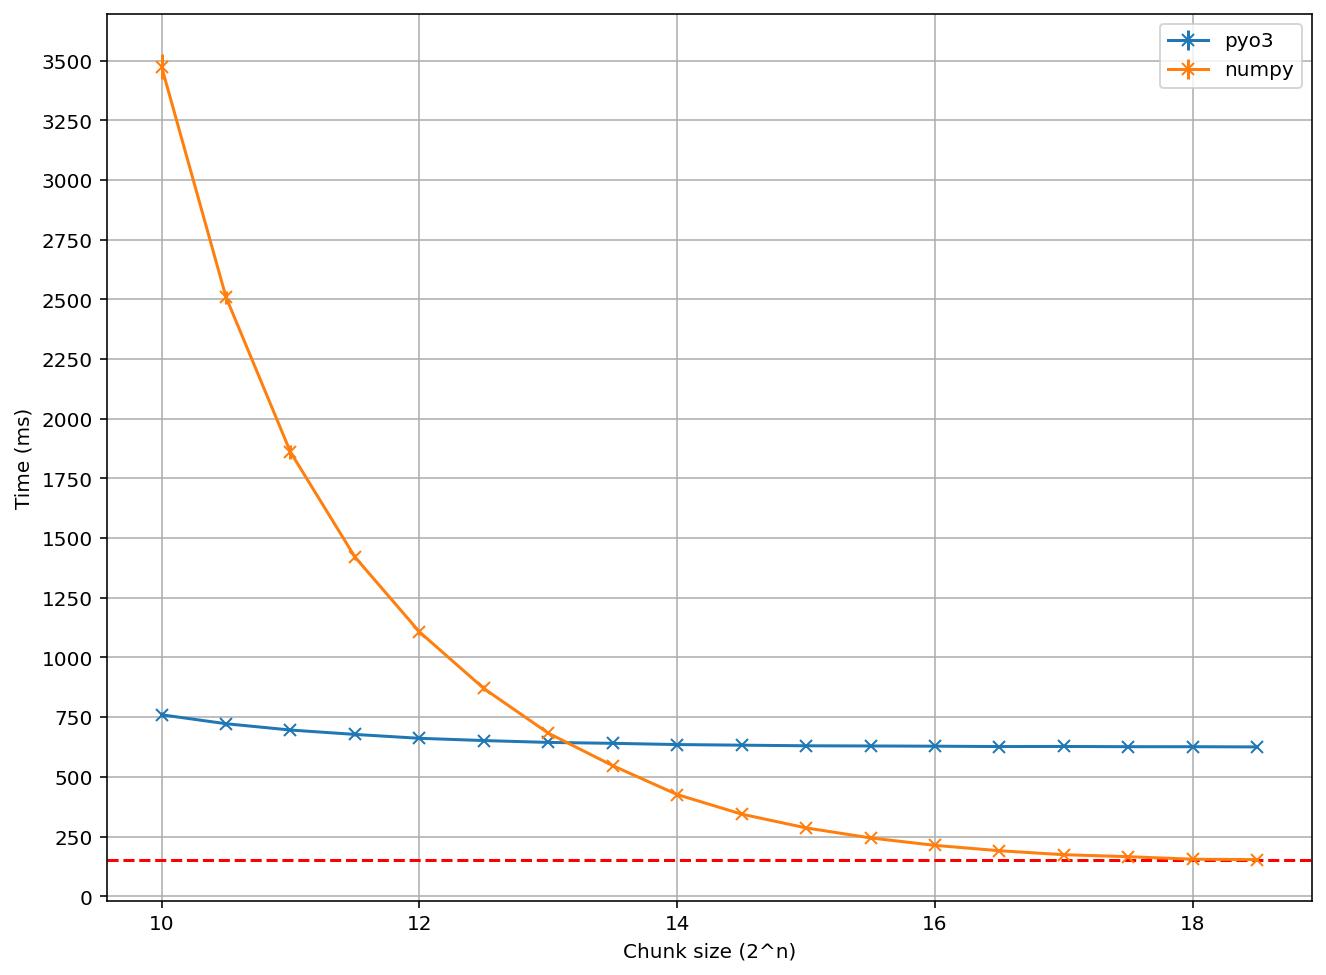

In [19]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.6, 8), dpi=144)
plt.grid(True)

plt.yticks(np.arange(0, 5000, 250))
#plt.xticks(alabels)
for name, args in umean.items():
    plt.errorbar(x=mlabels, y=args['y'], yerr=args['yerr'], fmt='x-', label=name)
npr = min(umean['numpy']['y'])
plt.axhline(npr, linestyle='--', color="red")

plt.xlabel('Chunk size (2^n)')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/mean.png')
plt.show()

In [20]:
print('chunked mean')
print(",\n".join(
    make_row(f"{k:.3}", (get_measures(umean[m])[i] for m in ('pyo3', 'numpy'))) for i, k in enumerate(mlabels)
))

chunked mean
[ 10.0 ], [ 759.9 $plus.minus$ 10.56 ], [ 3.475e+03 $plus.minus$ 53.26 ],
[ 10.5 ], [ 722.4 $plus.minus$ 7.956 ], [ 2.51e+03 $plus.minus$ 27.4 ],
[ 11.0 ], [ 696.0 $plus.minus$ 6.109 ], [ 1.86e+03 $plus.minus$ 29.16 ],
[ 11.5 ], [ 677.6 $plus.minus$ 5.118 ], [ 1.421e+03 $plus.minus$ 14.28 ],
[ 12.0 ], [ 661.4 $plus.minus$ 4.354 ], [ 1.107e+03 $plus.minus$ 13.74 ],
[ 12.5 ], [ 651.9 $plus.minus$ 3.613 ], [ 870.1 $plus.minus$ 12.52 ],
[ 13.0 ], [ 644.1 $plus.minus$ 2.497 ], [ 682.9 $plus.minus$ 4.2 ],
[ 13.5 ], [ 640.3 $plus.minus$ 4.441 ], [ 546.7 $plus.minus$ 7.181 ],
[ 14.0 ], [ 635.2 $plus.minus$ 4.231 ], [ 425.7 $plus.minus$ 5.086 ],
[ 14.5 ], [ 632.6 $plus.minus$ 2.779 ], [ 343.8 $plus.minus$ 3.869 ],
[ 15.0 ], [ 630.0 $plus.minus$ 3.308 ], [ 286.1 $plus.minus$ 5.175 ],
[ 15.5 ], [ 629.2 $plus.minus$ 3.21 ], [ 244.0 $plus.minus$ 3.43 ],
[ 16.0 ], [ 628.3 $plus.minus$ 2.759 ], [ 212.9 $plus.minus$ 2.755 ],
[ 16.5 ], [ 626.8 $plus.minus$ 3.805 ], [ 190.4 $plus.minus$ 2.1

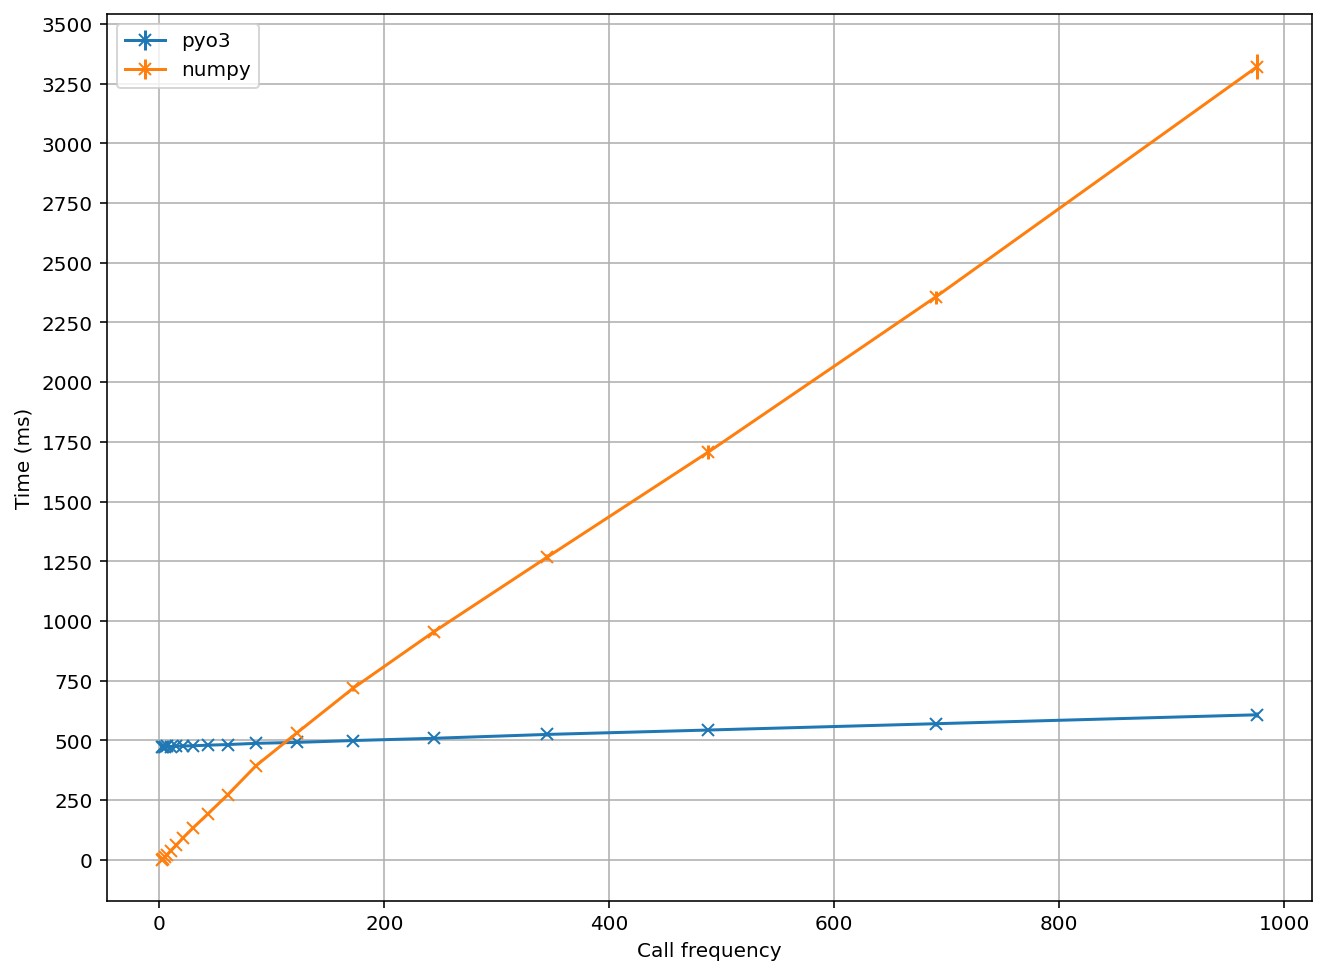

[np.float64(53.26446616247393), np.float64(27.396295111727923), np.float64(29.159748022383333), np.float64(14.275765664774521), np.float64(13.736520378740584), np.float64(12.521337786177474), np.float64(4.200229385270393), np.float64(7.180896989466802), np.float64(5.085837213281602), np.float64(3.868940383217198), np.float64(5.1750797636365045), np.float64(3.4301738537086797), np.float64(2.755035467406303), np.float64(2.168912729149482), np.float64(2.389148489873884), np.float64(1.5024871676286897), np.float64(1.9625849575382817), np.float64(2.7702487060430716)]


In [21]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.6, 8), dpi=144)
plt.grid(True)

imlabels = [int(1_000_000/2**v) for v in mlabels]
plt.yticks(np.arange(0, 5000, 250))
#plt.xticks(ialabels)
for name, args in umean.items():
    plt.errorbar(x=imlabels, y=args['y'] - npr, yerr=args['yerr'], fmt='x-', label=name)

plt.xlabel('Call frequency')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/add_mean.png')
plt.show()
print(max(m['yerr'] for m in umean.values()))

In [22]:
for name, args in umean.items():
    p, V = np.polyfit(imlabels, args['y'] - npr, 1, w=1/np.sqrt(args['yerr']), cov=True)
    V = np.sqrt(V)
    print(make_row(name, ((p[0], V[0][0]), (p[1], V[1][1]))))

[ pyo3 ], [ 0.1408 $plus.minus$ 0.001476 ], [ 473.1 $plus.minus$ 0.3195 ]
[ numpy ], [ 3.562 $plus.minus$ 0.08204 ], [ 14.75 $plus.minus$ 9.941 ]


/tmp/ipykernel_1875/3047004497.py:3: RuntimeWarning: invalid value encountered in sqrt
  V = np.sqrt(V)


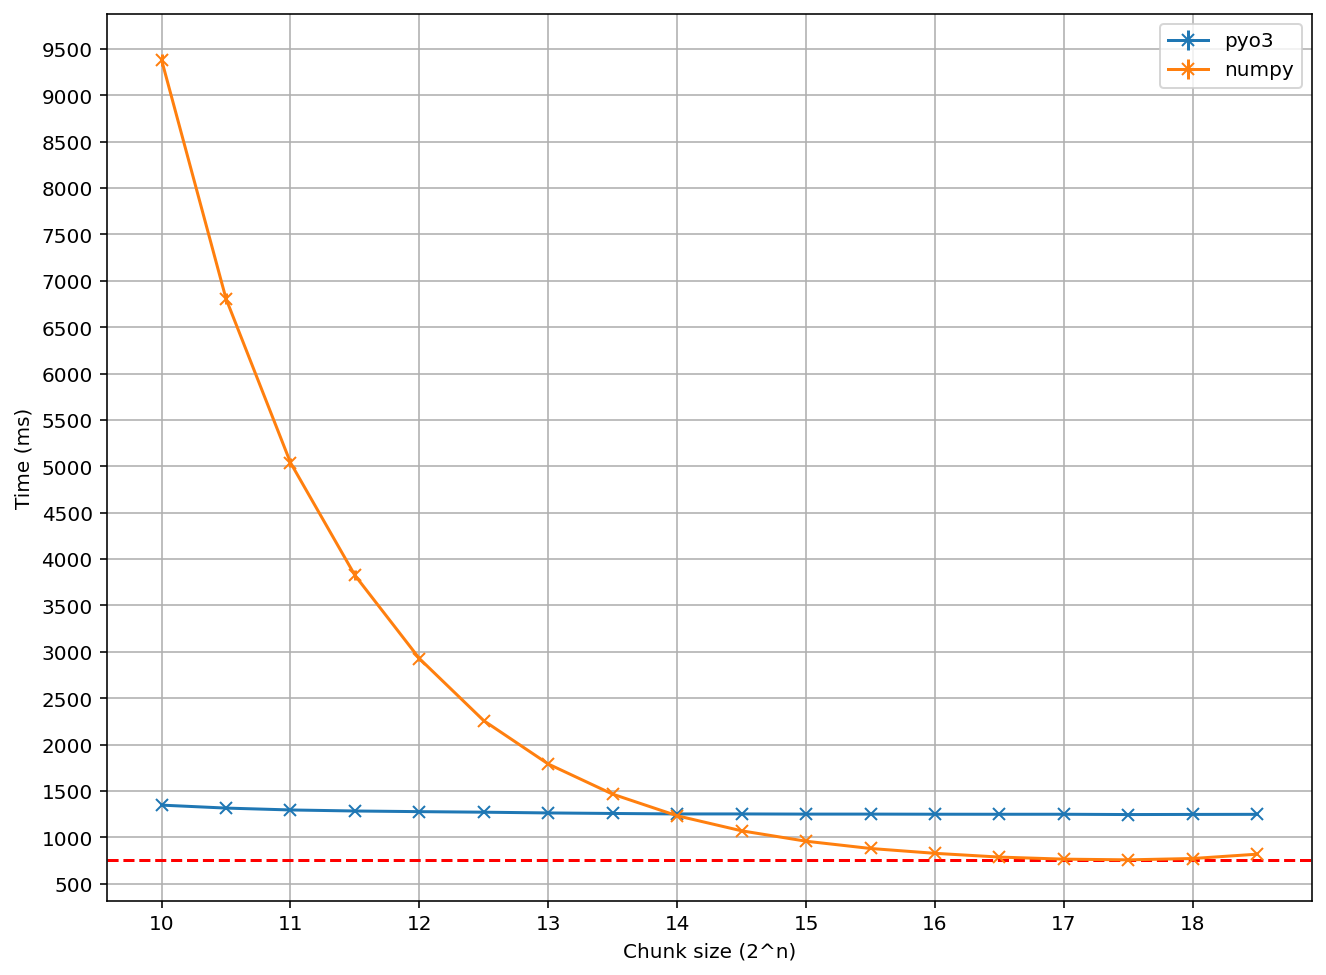

In [28]:
plt.figure(figsize=(len(umean['numpy']['x'])*0.6, 8), dpi=144)
plt.grid(True)

spr = min(ustd['numpy']['y'])
plt.yticks(np.arange(0, 10000, 500))
plt.xticks(alabels)
for name, args in ustd.items():
    plt.errorbar(x=mlabels, y=args['y'], yerr=args['yerr'], fmt='x-', label=name)
plt.axhline(spr, linestyle='--', color="red")

plt.xlabel('Chunk size (2^n)')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/std.png')
plt.show()

In [24]:
print('chunked std')
print(",\n".join(
    make_row(f"{k:.3}", (get_measures(ustd[m])[i] for m in ('pyo3', 'numpy'))) for i, k in enumerate(mlabels)
))

chunked std
[ 10.0 ], [ 1.348e+03 $plus.minus$ 11.59 ], [ 9.382e+03 $plus.minus$ 64.0 ],
[ 10.5 ], [ 1.316e+03 $plus.minus$ 5.457 ], [ 6.808e+03 $plus.minus$ 61.71 ],
[ 11.0 ], [ 1.296e+03 $plus.minus$ 5.033 ], [ 5.04e+03 $plus.minus$ 46.21 ],
[ 11.5 ], [ 1.285e+03 $plus.minus$ 8.125 ], [ 3.825e+03 $plus.minus$ 53.61 ],
[ 12.0 ], [ 1.278e+03 $plus.minus$ 3.923 ], [ 2.928e+03 $plus.minus$ 22.35 ],
[ 12.5 ], [ 1.272e+03 $plus.minus$ 5.9 ], [ 2.258e+03 $plus.minus$ 12.12 ],
[ 13.0 ], [ 1.264e+03 $plus.minus$ 8.286 ], [ 1.791e+03 $plus.minus$ 14.13 ],
[ 13.5 ], [ 1.258e+03 $plus.minus$ 4.963 ], [ 1.466e+03 $plus.minus$ 8.84 ],
[ 14.0 ], [ 1.253e+03 $plus.minus$ 3.192 ], [ 1.233e+03 $plus.minus$ 6.972 ],
[ 14.5 ], [ 1.253e+03 $plus.minus$ 3.767 ], [ 1.071e+03 $plus.minus$ 9.129 ],
[ 15.0 ], [ 1.251e+03 $plus.minus$ 2.522 ], [ 958.8 $plus.minus$ 9.865 ],
[ 15.5 ], [ 1.251e+03 $plus.minus$ 3.793 ], [ 880.5 $plus.minus$ 9.754 ],
[ 16.0 ], [ 1.25e+03 $plus.minus$ 2.485 ], [ 828.2 $plus.minus$ 6

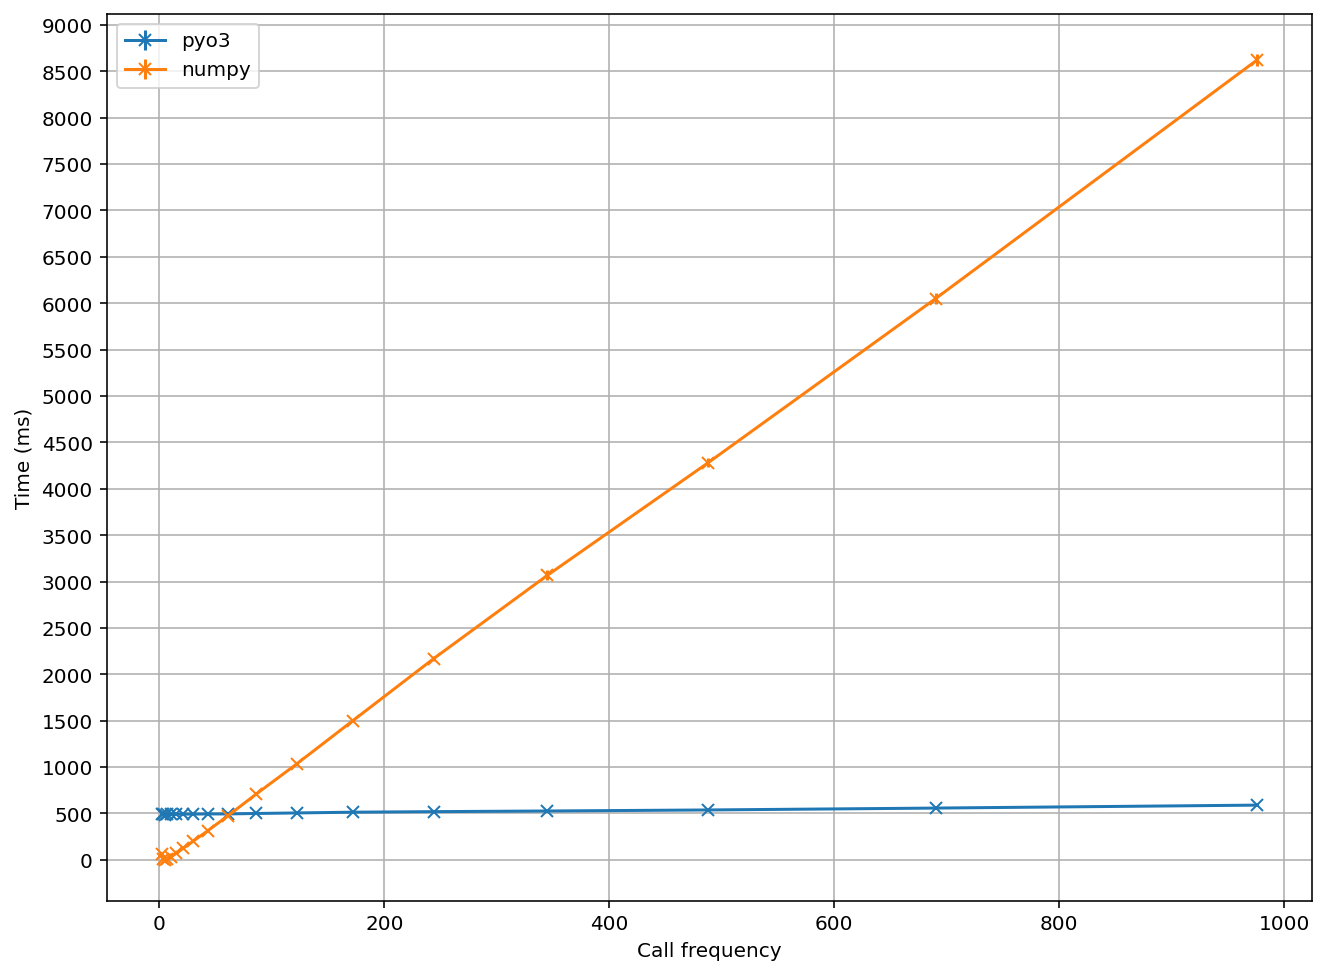

In [27]:
plt.figure(figsize=(len(ustd['numpy']['x'])*0.6, 8), dpi=144)
plt.grid(True)

plt.yticks(np.arange(0, 10000, 500))
for name, args in ustd.items():
    plt.errorbar(x=imlabels, y=args['y'] - spr, yerr=args['yerr'], fmt='x-', label=name)

plt.xlabel('Call frequency')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('plots/add_std.png')
plt.show()

In [26]:
for name, args in ustd.items():
    p, V = np.polyfit(imlabels, args['y'] - npr, 1, w=1/np.sqrt(args['yerr']), cov=True)
    V = np.sqrt(V)
    print(make_row(name, ((p[0], V[0][0]), (p[1], V[1][1]))))

[ pyo3 ], [ 0.1017 $plus.minus$ 0.002395 ], [ 1.095e+03 $plus.minus$ 0.5547 ]
[ numpy ], [ 8.878 $plus.minus$ 0.06025 ], [ 561.3 $plus.minus$ 8.442 ]


/tmp/ipykernel_1875/1348891480.py:3: RuntimeWarning: invalid value encountered in sqrt
  V = np.sqrt(V)
